In [ ]:
!pip install --upgrade pip
!pip install fosforml numpy pandas matplotlib scikit-learn seaborn python-dateutil
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15
!pip install fosforml 
!pip install fosforio
!pip install refractio
!pip install refractml
!pip install cloudpickle
!pip install -U cloudpickle

In [ ]:
!pip install seaborn scipy xgboost pandas dice-ml tabulate numpy scikit-learn pandas-profiling plotly matplotlib scipy statsmodels seaborn pydantic-settings

In [2]:
from fosforml.model_manager.snowflakesession import get_session

my_session = get_session()

In [28]:
df = 'ATTRITION_TABLE'

In [29]:
sf_df = my_session.sql("select * from {}".format(df))

In [30]:
import pandas as pd
pandas_df = sf_df.to_pandas()

In [31]:
pandas_df

,EMPLOYEE_ID,TENURE_MONTHS,BIRTH_YEAR,AGE,SENIORITY,SCHOOL_ENDDATE,MONTHS_AFTER_COLLEGE,PEOPLE_JOINED_BEFORE_AND_LEFT_IN_THIS_MONTH,PEOPLE_JOINED_AND_NEVER_LEFT,POPULATION,...,ORGANIZATION_TYPE,ORGANIZATION_OWNERSHIP,STATE,COUNTRY,GENDER,OVERTIME_HOURS,WORK_LIFE_BALANCE,BUSINESS_TRAVEL,ENVIRONMENT_SATISFACTION,USER_ID
0,95280676,43,1986,38,2,2009-01-31,30,0,0,0,...,Technology,Public,Illinois,United States,Male,16,Better,Travel Rarely,Very High,643748410
1,83315936,41,1988,36,2,2010-01-31,26,0,0,0,...,IT Services,Public,Massachusetts,United States,Male,3,Good,Travel Rarely,Medium,597456704
2,46251572,23,1989,35,2,2015-01-01,13,0,0,0,...,E-commerce,Private,Illinois,United States,Male,9,Bad,Travel Rarely,Medium,509036022
3,21546520,10,1982,42,2,2003-01-01,139,0,53,53,...,E-commerce,Private,Florida,United States,Male,6,Better,Travel Rarely,Very High,546019147
4,16097940,24,1986,38,3,2013-01-31,11,0,0,0,...,Technology,Public,Florida,United States,Male,4,Good,Non-Travel,Low,447760669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,18671063,19,1983,41,2,2009-01-31,8,0,82,82,...,E-commerce,Private,Illinois,United States,Female,4,Good,Travel Rarely,Low,643748410
299996,52652696,63,1976,48,3,1998-01-01,132,34,93,127,...,Technology,Private,Florida,United States,Male,11,Best,Travel Rarely,High,7897053
299997,90024647,33,1991,33,1,2014-01-31,9,0,0,0,...,Financial Services,Private,California,United States,Female,9,Good,Travel Rarely,Very High,810960945
299998,46230228,9,1974,50,1,1994-01-01,192,0,160,160,...,Technology,Public,Illinois,United States,Female,9,Bad,Travel Rarely,High,329089382


In [32]:
print(pandas_df.isnull().sum())

EMPLOYEE_ID                                        0
TENURE_MONTHS                                      0
BIRTH_YEAR                                         0
AGE                                                0
SENIORITY                                          0
SCHOOL_ENDDATE                                     0
MONTHS_AFTER_COLLEGE                               0
PEOPLE_JOINED_BEFORE_AND_LEFT_IN_THIS_MONTH        0
PEOPLE_JOINED_AND_NEVER_LEFT                       0
POPULATION                                         0
CHURN_OTHER                                        0
CHURN_F                                            0
SUM_OF_TENURE                                      0
SUM_OF_AGE                                         0
JOB_STARTDATE                                      0
JOB_ENDDATE                                    90076
SALARY                                             0
JOB_SATISFACTION                                   0
PERCENTAGE_SALARY_HIKE                        

In [33]:
Original_df = pandas_df.dropna()

In [34]:
print(Original_df.isnull().sum())

EMPLOYEE_ID                                    0
TENURE_MONTHS                                  0
BIRTH_YEAR                                     0
AGE                                            0
SENIORITY                                      0
SCHOOL_ENDDATE                                 0
MONTHS_AFTER_COLLEGE                           0
PEOPLE_JOINED_BEFORE_AND_LEFT_IN_THIS_MONTH    0
PEOPLE_JOINED_AND_NEVER_LEFT                   0
POPULATION                                     0
CHURN_OTHER                                    0
CHURN_F                                        0
SUM_OF_TENURE                                  0
SUM_OF_AGE                                     0
JOB_STARTDATE                                  0
JOB_ENDDATE                                    0
SALARY                                         0
JOB_SATISFACTION                               0
PERCENTAGE_SALARY_HIKE                         0
PERFORMANCE_RATING                             0
OVER_TIME           

In [35]:
df = Original_df.drop(["USER_ID", "EMPLOYEE_ID", "JOB_STARTDATE", "JOB_ENDDATE", "SCHOOL_ENDDATE","CHURN_VALUE","PEOPLE_JOINED_BEFORE_AND_LEFT_IN_THIS_MONTH","PEOPLE_JOINED_AND_NEVER_LEFT","POPULATION","CHURN_OTHER","CHURN_F","SUM_OF_TENURE","SUM_OF_AGE"], axis = 1)

In [36]:
df

,TENURE_MONTHS,BIRTH_YEAR,AGE,SENIORITY,MONTHS_AFTER_COLLEGE,SALARY,JOB_SATISFACTION,PERCENTAGE_SALARY_HIKE,PERFORMANCE_RATING,OVER_TIME,...,COMPANY_NAME,ORGANIZATION_TYPE,ORGANIZATION_OWNERSHIP,STATE,COUNTRY,GENDER,OVERTIME_HOURS,WORK_LIFE_BALANCE,BUSINESS_TRAVEL,ENVIRONMENT_SATISFACTION
0,43,1986,38,2,30,58685.67,Very High,18,Excellent,Yes,...,SecureTech Solutions,Technology,Public,Illinois,United States,Male,16,Better,Travel Rarely,Very High
1,41,1988,36,2,26,65996.91,Medium,21,Excellent,No,...,GreenByte Solutions,IT Services,Public,Massachusetts,United States,Male,3,Good,Travel Rarely,Medium
2,23,1989,35,2,13,47464.34,Low,13,Low,No,...,BrightStart Ventures,E-commerce,Private,Illinois,United States,Male,9,Bad,Travel Rarely,Medium
3,10,1982,42,2,139,62367.17,Medium,16,Outstanding,No,...,BrightStart Ventures,E-commerce,Private,Florida,United States,Male,6,Better,Travel Rarely,Very High
4,24,1986,38,3,11,59462.37,High,11,Good,No,...,Pinnacle Technologies,Technology,Public,Florida,United States,Male,4,Good,Non-Travel,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299991,54,1979,45,2,104,62336.69,High,11,Excellent,No,...,AlphaRetail Ltd.,Retail,Public,Massachusetts,United States,Female,10,Bad,Travel Rarely,Low
299992,25,1997,27,1,9,54305.18,Very High,13,Excellent,No,...,GreenWorld Foundation,Environmental,Non-Profit,California,United States,Female,6,Good,Travel Frequently,Low
299993,1,1994,30,1,10,40613.05,High,11,Good,Yes,...,Horizon Financials,Financial Services,Private,California,United States,Female,3,Bad,Travel Rarely,Medium
299994,9,1990,34,4,72,79412.92,Very High,11,Excellent,No,...,BridgePoint Capital,Investment,Public,California,United States,Male,8,Good,Travel Rarely,Very High


In [37]:
CATEGORICAL_COLUMNS = ["MAPPED_ROLE","SEX", "ETHNICITY","ORGANIZATION_TYPE", "ORGANIZATION_OWNERSHIP","COMPANY_NAME","CITY","STATE","DISTANCE",
                       "NEW_DEVICE_INDICATOR","BUSINESS_TRAVEL","ENVIRONMENT_SATISFACTION","JOB_SATISFACTION","MARITAL_STATUS","OVER_TIME","PERFORMANCE_RATING","RELATIONSHIP_SATISFACTION","WORK_LIFE_BALANCE"]
NUMERICAL_COLUMNS = ["SALARY", "SENIORITY", "TENURE_MONTHS", "MONTHS_AFTER_COLLEGE", "BIRTH_YEAR","AGE","OVERTIME_HOURS","PERCENTAGE_SALARY_HIKE"]
LABEL_COLUMNS = ["CHURN"]
DROPPED_COLUMNS = ["USER_ID", "EMPLOYEE_ID", "JOB_STARTDATE", "JOB_ENDDATE", "SCHOOL_ENDDATE","CHURN_VALUE","PEOPLE_JOINED_BEFORE_AND_LEFT_IN_THIS_MONTH","PEOPLE_JOINED_AND_NEVER_LEFT","POPULATION","CHURN_OTHER","CHURN_F","SUM_OF_TENURE","SUM_OF_AGE"]
OUTPUT_COLUMNS = ["PREDICTION"]

In [38]:
# Filter feature columns
feature_columns = CATEGORICAL_COLUMNS + NUMERICAL_COLUMNS
feature_columns = [col for col in feature_columns if col in Original_df.columns]
LABEL_COLUMNS = [col for col in LABEL_COLUMNS if col in Original_df.columns]
 
# Split data into features and labels
X = Original_df[feature_columns + DROPPED_COLUMNS]
y = Original_df[LABEL_COLUMNS].values.ravel()  # Flatten to 1D array for consistency

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
 
# Define transformers
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
)
 
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    MinMaxScaler(clip=True)
)
 
# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, CATEGORICAL_COLUMNS),
        ('num', numerical_transformer, NUMERICAL_COLUMNS)
    ]
)
 
# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

pipeline.fit(X_train, y_train)
result = pipeline.predict(X_test)

In [16]:
result

array([0, 0, 1, ..., 1, 0, 0])

In [17]:
from joblib import dump, load
filename = "Attrition.joblib"
dump(pipeline, filename)

['Attrition.joblib']

In [18]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)

In [19]:
from refractml import *

from refractml.constants import MLModelFlavours

In [20]:
@scoring_func
def score(model, request):
    payload_dict = request.json["payload"]
    data_json = eval(payload)
    data = pd.DataFrame([data_json])
    prediction = str(model.predict(data)[0])
    return prediction

In [21]:
import requests
import datetime
import pandas as pd 
payload = str(X_test.iloc[123].to_dict())
req = requests.Request()
req.json = {"payload": payload}

print(score(pipeline, req))

1


In [22]:
req.json

{'payload': "{'ROLE': 'Warehouse Associate', 'ETHNICITY': 'White', 'ORGANIZATION_TYPE': 'E-commerce', 'ORGANIZATION_OWNERSHIP': 'Private', 'COMPANY_NAME': 'BrightStart Ventures', 'CITY': 'Cleveland', 'STATE': 'Ohio', 'DISTANCE': '5-10 miles', 'COUNTRY': 'United States', 'GENDER': 'Female', 'BUSINESS_TRAVEL': 'Travel Rarely', 'ENVIRONMENT_SATISFACTION': 'Low', 'JOB_SATISFACTION': 'High', 'MARITAL_STATUS': 'Married', 'OVER_TIME': 'Yes', 'PERFORMANCE_RATING': 'Outstanding', 'RELATIONSHIP_SATISFACTION': 'High', 'WORK_LIFE_BALANCE': 'Better', 'CHURN_STATUS_TABLE': 'TRUE', 'DEGREE_CLEAN': 'Other', 'SALARY': 36707.29, 'SENIORITY': 1, 'TENURE_MONTHS': 20, 'MONTHS_AFTER_COLLEGE': 55, 'BIRTH_YEAR': 1988, 'AGE': 36, 'OVERTIME_HOURS': 10, 'PERCENTAGE_SALARY_HIKE': 13, 'USER_ID': 698929203, 'EMPLOYEE_ID': '58831977', 'JOB_STARTDATE': datetime.date(2017, 10, 1), 'JOB_ENDDATE': datetime.date(2019, 8, 1), 'SCHOOL_ENDDATE': datetime.date(2011, 1, 31), 'CHURN_OTHER': 0, 'PEOPLE_JOINED_BEFORE_AND_LEFT_IN

In [23]:
payload  = {"payload": X_test.iloc[0].to_dict()}
payload

{'payload': {'ROLE': 'Warehouse Associate',
  'ETHNICITY': 'Hispanic',
  'ORGANIZATION_TYPE': 'Environmental',
  'ORGANIZATION_OWNERSHIP': 'Non-Profit',
  'COMPANY_NAME': 'GreenWorld Foundation',
  'CITY': 'Chicago',
  'STATE': 'Illinois',
  'DISTANCE': '>10 miles',
  'COUNTRY': 'United States',
  'GENDER': 'Male',
  'BUSINESS_TRAVEL': 'Travel Rarely',
  'ENVIRONMENT_SATISFACTION': 'Medium',
  'JOB_SATISFACTION': 'Very High',
  'MARITAL_STATUS': 'Divorced',
  'OVER_TIME': 'No',
  'PERFORMANCE_RATING': 'Outstanding',
  'RELATIONSHIP_SATISFACTION': 'High',
  'WORK_LIFE_BALANCE': 'Bad',
  'CHURN_STATUS_TABLE': 'FALSE',
  'DEGREE_CLEAN': 'Masters Degree',
  'SALARY': 64934.25,
  'SENIORITY': 2,
  'TENURE_MONTHS': 24,
  'MONTHS_AFTER_COLLEGE': 6,
  'BIRTH_YEAR': 1986,
  'AGE': 38,
  'OVERTIME_HOURS': 8,
  'PERCENTAGE_SALARY_HIKE': 13,
  'USER_ID': 114370064,
  'EMPLOYEE_ID': '44340232',
  'JOB_STARTDATE': datetime.date(2021, 9, 1),
  'JOB_ENDDATE': datetime.date(2023, 11, 1),
  'SCHOOL_ENDD

In [24]:
result = pipeline.predict(X_test)
result_prob = pipeline.predict_proba(X_test)
pred_df = X_test.copy()
result = result
result_prob = result_prob
pred_df["PREDICTION"] = result
pred_df["PROB"] = result_prob[:, 1]

In [25]:
from sklearn.metrics import classification_report, log_loss, roc_auc_score
 
# Check lengths
print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred))
 
# Print classification report
print(classification_report(y_test, y_pred))
 
# Calculate accuracy
accuracy = sum(y_test == y_pred) / len(y_test)
print("Accuracy:", accuracy)
 
# Calculate additional metrics
log_loss_value = log_loss(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob[:, 1])  # Assuming class 1 is the positive class
 
print("Log Loss:", log_loss_value)
print("ROC AUC Score:", roc_auc)

Length of y_test: 41985
Length of y_pred: 41985
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24137
           1       1.00      1.00      1.00     17848

    accuracy                           1.00     41985
   macro avg       1.00      1.00      1.00     41985
weighted avg       1.00      1.00      1.00     41985

Accuracy: 1.0
Log Loss: 1.1648022296842728e-05
ROC AUC Score: 1.0


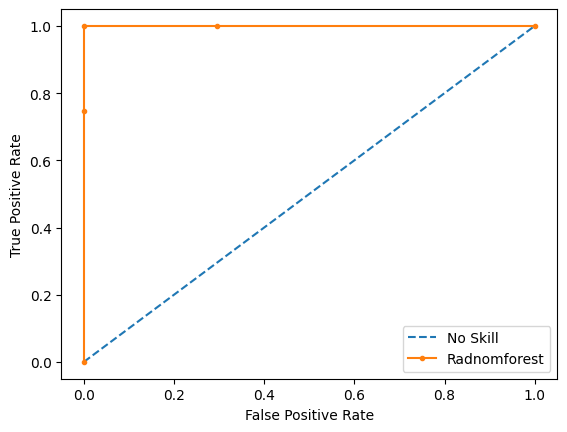

In [26]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, pred_df["PROB"])
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, pred_df["PROB"])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Radnomforest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()